In [1]:
import pandas as pd
import numpy as np
import cloudpickle
import sklearn

from sklearn import preprocessing
import locale
locale.setlocale(locale.LC_ALL, '')

df=pd.read_csv("df_train.csv.gz")
df = df.dropna(subset=['overall_ranking'])

cleaned_cols = []
dropped = []
status_cols = []
time_cols = ['completed','created','result.duration.pace','result.duration.chip','checkin_time','modified']
drop_cols = ['id','rank','lineage','shipments','images','body.type','color','unit','results.splits','splits','name','coupon','sharing','bracket','created','slug','organizations','location','description','fundraising','registration','confirmation_number','sections','brackets.type', 'event.results_posted', 'photos', 'certificate', 'event.results_searchable', 'corral.wave', 'result.duration', 'counts.participants.expected']
# drop_cols = ['id','rank','lineage','shipments','images','body.type','color','unit','results.splits','splits','name','coupon','sharing','bracket','created','slug','organizations','location','description','fundraising','registration','confirmation_number','sections','brackets.type']
keep_cols_train = ['overall_ranking','location.name','location.city','fundraising.goal','hometown']
keep_cols_test = []

for name in df.columns:
    print(name)
    if 'clean' in name:
        cleaned_cols.append(name)
    if name not in keep_cols_train:
        if 'time' in name or 'date' in name:
            time_cols.append(name)
        if 'status' in name:
            status_cols.append(name)
        for col in drop_cols:
            if col in name:
                print('dropped: ', name)
                dropped.append(name)
            else:
                keep_cols_test.append(name)
                keep_cols_train.append(name)

print('time_cols',time_cols)
print('status_cols',status_cols)
print('cleaned',cleaned_cols)
print('dropped',dropped)
print('keep_cols_train',keep_cols_train)
print('keep_cols_test',keep_cols_test)

/var/folders/bz/4d3rd17s26gfx04bzf74pxl80000gq/T/ipykernel_38877/3767882062.py:10: DtypeWarning: Columns (13,16,17,20,21,27,38,45,46,47,57,66,67,72,73,74,79,104,105,119,121,124) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("df_train.csv.gz")


lineage.event_series.id
dropped:  lineage.event_series.id
dropped:  lineage.event_series.id
lineage.event_series.name
dropped:  lineage.event_series.name
dropped:  lineage.event_series.name
lineage.previous_event.id
dropped:  lineage.previous_event.id
dropped:  lineage.previous_event.id
lineage.previous_event.name
dropped:  lineage.previous_event.name
dropped:  lineage.previous_event.name
lineage.previous_event.slug
dropped:  lineage.previous_event.slug
dropped:  lineage.previous_event.slug
location.name
location.city
location.state
dropped:  location.state
location.zip
dropped:  location.zip
location.country_name
dropped:  location.country_name
dropped:  location.country_name
location.country_code
dropped:  location.country_code
location.coordinates.latitude
dropped:  location.coordinates.latitude
location.coordinates.longitude
dropped:  location.coordinates.longitude
counts.participants.expected
dropped:  counts.participants.expected
counts.participants.registered
counts.participants

In [2]:
from sklearn.preprocessing import LabelEncoder

drop_cols = [*dropped, *time_cols]
def clean_data(data, clean_cols=cleaned_cols,drop_cols=drop_cols):
    columns_to_drop = ['sex']
    
    if 'sex' in data.columns:
        data = data[(data['sex'] == 'Female') | (data['sex'] == 'Male')]
        data.loc['sex'] = data['sex'].replace({'F':'Female','M':'Male'})
        data.loc['is_female'] = data['sex'] == 'Female'

    data = data.replace({'False':False,'True':True})
    
    if 'age' in data.columns:
        data = data[(data['age'] >= 8) | (data['age'] < 80)]
    
    
    if 'fundraising.goal' in data.columns:
        data['fundraising.goal'] = data['fundraising.goal'].apply(lambda x: float(x.replace(',','')) if type(x) == str else x)
    
    categorical = [*clean_cols,'location.city','location.name','result.hometown','hometown']
    le = preprocessing.LabelEncoder()
    for col in categorical:
        if col in data.columns:
            data[col] = le.fit_transform(data[col])
            # print(data[col])

    columns_to_drop = np.intersect1d(data.columns,drop_cols + columns_to_drop)
    data = data.drop(columns_to_drop, axis=1)#.fillna(-1)
    return data

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline

# df=pd.read_csv("df_train.csv.gz")
training_df=df.query("`event.id`!='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'").copy()
training_df = clean_data(training_df)
# print(training_data)

# This is a custom transformer to demonstrate how you might modify the data for feature
# selection or engineering before applying a given model. In this example I am only
# doing feature selection, and passing to the next element in the pipeline the age
# and bib number for the runner. Thus only two features will be used in my predictive model.
# There are other ways to do this
class CustomTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        # Just select the features we want
        Xprime = clean_data(X)
        return Xprime

# I build a very basic pipeline which is made up of three stages. In the first, my
# custom transform is called and reduces the DataFrame to just two columns. In the
# second I use a built-in transformer from sklearn to bucket users based on their
# bib number, perhaps as a proxy for "how early did they sign up". In the final step
# I want to use a LinearRegression() regressor.

# There are two main concerns I need to address. First, I need to be resilient to bad
# data which might address. So I know the LinearRegression() object can't handle
# missing data, so I need to deal with that. This was done in the CustomeTransformer()
# already.

# Second, I actually need to be ranking results, not regressing. Depending upon your
# model you need to consider this carefully. Here is a fine catch all if you
# are using regression, and object which just ranks the results in order. This is
# called monkey patching and replaces the LinearRegression() object's predict()
# function with a wrapper
mlp = MLPRegressor()
mlp.original_predict=mlp.predict

def new_predict(X):
    # run the old regression method
    rankings=mlp.original_predict(X)
    # now calculate and return the ranks of each item instead
    # we need to add a +1 because the lowest rank is a 1, not a 0
    # it's unfortunate, the first athletic competition was probably run by R users...
    return rankings.squeeze().argsort()+1

# Now we overwrite (monkey patch) the predict() function with our own implementation
mlp.predict=new_predict

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
numeric_features = training_df.select_dtypes(include=['int64', 'float64']).drop("overall_ranking",axis=1).columns
print(numeric_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
      ])

# And build our pipeline object
ct = CustomTransformer()
reduce = TruncatedSVD()
pipe = make_pipeline( ct, preprocessor, reduce, mlp )

# This is just one way to do this, you could also implement a new estimator with the
# predict interface and build all of your logic in there. The benefit of the
# pipeline is that you can rapidly change the logic and try different pipelines using
# common methods from sklearn. When the pipeline gets complicated, you can also
# visualize it...

from sklearn import set_config
set_config(display="diagram")
display(pipe)

# And I'm going to pass in all of my potential columns for consideration. Note: The
# example pipeline I built is going to reduce this to just the two columns I'm interested
# in, so this is a safe thing to do. But be aware, the holdout set does not have all of
# the data the training set might, because of leakage, so you need to think about this
# and not make assumptions. You can see how I built the holdout set at the bottom of
# this notebook
X=set(training_df.columns)-{'overall_ranking'}

# The ranking is what we aim to predict
y={'overall_ranking'}

# Now I fit() the pipeline. You'll note that the outcomes I need to squeeze() to ensure
# it's a one dimensional structure and not a DataFrame
for col in training_df.columns:
    print(col)
fitted_pipe=pipe.fit(training_df[X],training_df[y].squeeze().to_numpy())


/var/folders/bz/4d3rd17s26gfx04bzf74pxl80000gq/T/ipykernel_38877/3560171489.py:9: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  data.loc['sex'] = data['sex'].replace({'F':'Female','M':'Male'})
/var/folders/bz/4d3rd17s26gfx04bzf74pxl80000gq/T/ipykernel_38877/3560171489.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc['sex'] = data['sex'].replace({'F':'Female','M':'Male'})
/var/folders/bz/4d3rd17s26gfx04bzf74pxl80000gq/T/ipykernel_38877/3560171489.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

Index(['location.name', 'location.city', 'counts.participants.registered',
       'counts.participants.limit', 'fundraising.goal', 'age', 'bib', 'price',
       'hometown', 'event.no_bib', 'category.registered.distance.quantity',
       'category.registered.results_log_allow',
       'category.registered.user_photo_upload_allow',
       'category.completed.distance.quantity', 'team.bib', 'result.hometown',
       'result.finished', 'result.disqualified', 'photo'],
      dtype='object')


Pipeline(steps=[('customtransformer', CustomTransformer()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['location.name', 'location.city', 'counts.participants.registered',
       'counts.participants.limit', 'fundraising.goal', 'age', 'bib', 'price',
       'hometown', 'event.no_bib', 'category.registered.distance.quantity',
       'category.registered.results_log_allow',
       'category.registered.user_photo_upload_allow',
       'category.completed.distance.quantity', 'team.bib', 'result.hometown',
       'result.finished', 'result.disqualified', 'photo'],
      dtype='object'))])),
                ('truncatedsvd', TruncatedSVD()),
                ('mlpregressor', MLPRegressor())])

location.name
location.city
counts.participants.registered
counts.participants.limit
fundraising.goal
age
bib
price
hometown
event.no_bib
category.registered.distance.quantity
category.registered.results_log_allow
category.registered.user_photo_upload_allow
category.completed.distance.quantity
team.bib
result.hometown
result.finished
result.disqualified
photo
overall_ranking


/var/folders/bz/4d3rd17s26gfx04bzf74pxl80000gq/T/ipykernel_38877/4089009655.py:97: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  fitted_pipe=pipe.fit(training_df[X],training_df[y].squeeze().to_numpy())
/var/folders/bz/4d3rd17s26gfx04bzf74pxl80000gq/T/ipykernel_38877/4089009655.py:97: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  fitted_pipe=pipe.fit(training_df[X],training_df[y].squeeze().to_numpy())
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [4]:
# holdout_data=pd.read_csv("df_train.csv.gz")
holdout_data=df.query("`event.id`=='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'").copy()

# This is the scoring function to determine model fitness
def score(left: pd.DataFrame, right: pd.DataFrame):
    '''
    Calculates the difference between the left and the right when considering rank of items. 
    This scoring function requires that the two DataFrames have identical indicies, and that
    they each contain only one column of values and no missing values. Props to Blake Atkinson
    for providing MWE indicating issues with autograder version #1.
    '''
    assert(type(left)==pd.DataFrame)
    assert(type(right)==pd.DataFrame)
    assert(len(left)==len(right))
    assert(not np.any(np.isnan(left)))
    assert(not np.any(np.isnan(right)))
    assert(left.index.equals(right.index))
    # convert to ndarrays
    left=left.squeeze()
    right=right.squeeze()
    return np.sum(np.abs(left-right))/(len(left)*(len(left)-1))

# This function runs the prediction model agains a given event/category pair. It
# intentionally loads the student model each time to avoid accidental leakage of data
# between events.
def evaluate(data, fitted_pipe):
    # Load student pipeline
    # fitted_pipe = cloudpickle.load(open(pipeline_file,'rb'))
    
    # Separate out the X and y
    X=list(set(data.columns)-{'overall_ranking'})
    y=['overall_ranking']
    
    # Drop any missing results (DNFs)
    data=data.dropna(subset=['overall_ranking'])
    
    print(data.shape)
    # print(data[X])
    # Ensure there is data to actually predict on
    if len(data)==0:
        print('no data')
        return np.nan

    # TODO why?
    # if 'index' not in data or (len(fitted_pipe.predict(data[X])) != len(data.index)):
    #     print('uneven length')
    #     print(len(data.index), len(fitted_pipe.predict(data[X])))
    #     return np.nan

    prediction_score = 0.0
    try:
        # Predict on unseen data
        predictions=pd.DataFrame(fitted_pipe.predict(data[X]),data.index)
        # if len(predictions)==0:
        #     print('no predictions')
        #     print(fitted_pipe.predict(data[X]))
        #     return np.nan
        
        observed=data[y]
        # print(fitted_pipe.predict(data[X]))
        # print(predictions)
        
        # Generate rankings within this bracket
        observed=pd.DataFrame(data[y].rank(),data.index)
        
        prediction_score = score(observed,predictions)
        print(prediction_score)
    except ValueError:
        pass
    # except AttributeError:
    #     pass
    
    # Return the ratio of the student score
    return pd.Series({"score":prediction_score})

# Student solution
# pipeline_file='pipeline.cloudpickle'

# Run prediction on each group
results=holdout_data.groupby(["event.id","clean_categories.name"]).apply(evaluate, fitted_pipe)


(5113, 126)
0.33879843701363277


/var/folders/bz/4d3rd17s26gfx04bzf74pxl80000gq/T/ipykernel_38877/3560171489.py:9: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  data.loc['sex'] = data['sex'].replace({'F':'Female','M':'Male'})


                                                               score
event.id                             clean_categories.name          
583f013a-1e54-4906-87f7-2b625206f5f9 5k                     0.338798
0.33879843701363277


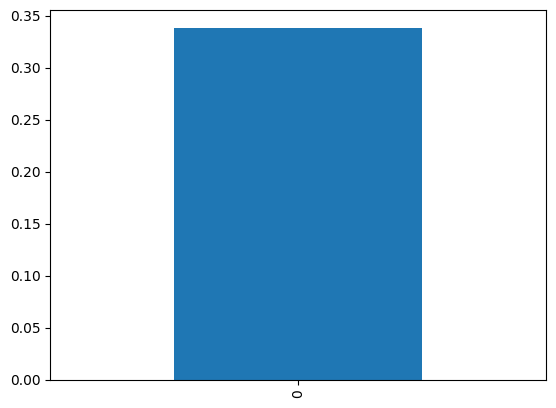

In [5]:
# Display the results, uncomment this for your own display
results.reset_index()['score'].plot.bar();
print(results)

# This is the student final grade
print(np.average(results))